# Age Estimation based on Human Voice

<br>
Play an audio file.

In [1]:
from pygame import mixer

def play_sound(path):
    mixer.init()
    mixer.music.load(path)
    mixer.music.play()
    
#play_sound("cv_corpus_v1\cv-valid-train\sample-000000.mp3")

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


<br>
Get the max length of audio files.

In [2]:
from os import listdir
from os.path import join

def get_max_length():
    max_length = 0 
    dirs = ["cv-invalid", "cv-other-dev", "cv-other-test", "cv-other-train", "cv-valid-dev", "cv-valid-test", "cv-valid-train"]
    for dir in dirs:
        print(dir)
        for file in listdir(join("cv_corpus_v1", "wav-files", dir)):
            _, audio = wavfile.read(join("cv_corpus_v1", "wav-files", dir, file))
            max_length = max(len(audio), max_length)
    return max_length
                        
#max_length = get_max_length()
max_length = 695060352

<br>
Get info from the dataset.

In [3]:
import pandas as pd

def get_dataframe(path):
    df = pd.read_csv(path)
    return df[pd.notna(df['age'])]

df = get_dataframe(join("cv_corpus_v1", "cv-valid-train.csv"))
df.head(10)

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN
20,cv-valid-train/sample-000020.mp3,it was faintly marked with transverse stripes ...,5,1,thirties,male,england,NaN
23,cv-valid-train/sample-000023.mp3,i had seen all that it would presently bring me,5,0,thirties,male,us,NaN
26,cv-valid-train/sample-000026.mp3,two years ago right here on this spot i had a ...,4,0,twenties,female,australia,NaN
27,cv-valid-train/sample-000027.mp3,don't let them see that you're afraid the alch...,3,0,twenties,male,australia,NaN
29,cv-valid-train/sample-000029.mp3,the fire alarm went off again but when i looke...,1,0,thirties,male,indian,NaN


In [4]:
import numpy as np

def get_mp3_name(path):
    return "{}.mp3".format(path[:-4]).split("wav-files\\")[1].replace("\\", "/")

def get_age(df, path):
    path = get_mp3_name(path)
    return df.loc[df['filename'] == path]["age"].values[0]

gender_dict = {"male": -1, "female": +1, "other": 0}
def get_gender(df, path):
    path = get_mp3_name(path)
    try:
        gender = df.loc[df['filename'] == path]["gender"].values[0]
        return gender_dict[gender]
    except:
        return gender_dict["other"]
    

print(get_age(df, join("cv_corpus_v1", "wav-files", "cv-valid-train", "sample-000020.wav")))
print(get_gender(df, join("cv_corpus_v1", "wav-files", "cv-valid-train", "sample-000020.wav")))

thirties
-1


<br> 
Get the spectrogram of an audio file.

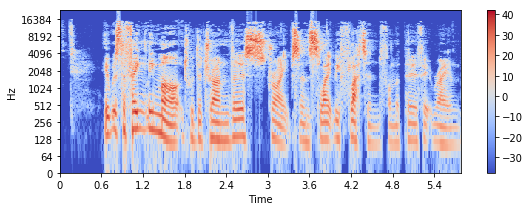

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def get_spectrogram(path, sampling_rate = 48000, display = True):
    # Load an audio file as a floating point time series.
    audio , _ = librosa.load(path, sr=sampling_rate)

    # Short-time Fourier transform (STFT).
    stft = abs(librosa.stft(audio))

    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    spectrogram = librosa.amplitude_to_db(stft)

    if display:
        plt.figure(figsize=(9, 3))
        librosa.display.specshow(spectrogram, sr=sampling_rate, x_axis='time', y_axis='log')
        plt.colorbar()
    return spectrogram


_ = get_spectrogram(join("cv_corpus_v1", "wav-files", "cv-valid-train", "sample-000020.wav"))

<br>
Feature Extraction:

* gender
* spectral_centroid computes the "average" frequency at each frame, where frequencies are weighted relatively by their energy.
* spectral_bandwidth similar to centroid, but for variance (or other moments).
* spectral_rolloff essentially the maximum: finds the frequency f such that almost all of the energy (for example 95%) in the frame is at frequencies below f. If you set the roll-off to a small fraction (say, 10%), this would give you an estimate of the effective minimum frequency.
* The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually 20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.


In [7]:
import sklearn

def feature_extraction(path, sampling_rate = 48000):
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = get_gender(df, path)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return np.asarray(features, dtype=float)
    
        
features = feature_extraction(join("cv_corpus_v1", "wav-files", "cv-valid-train", "sample-000020.wav"))
print("features: ", features)
print("shape: ", features.shape)

features:  [-1.00000000e+00  3.96891232e+03  2.91252107e+03  6.71275035e+03
 -2.92270602e+02  9.61654429e+01 -5.19889843e+01  4.70060891e+01
 -1.41496992e+01  1.91754064e+01 -1.54290157e+01 -2.08433772e+00
 -2.29711672e+00 -9.35190538e+00 -6.93357493e+00 -6.12214394e+00
  6.41517699e+00 -8.65743293e+00 -3.54438021e+00 -2.85235548e+00
 -2.35155632e+00 -7.71120655e-01  6.51453104e-01 -9.10067695e+00]
shape:  (24,)


<br>
Extract features and save them in new csv files.

In [8]:
import csv

def get_wav_name(path):
    info = path.split("/")
    filename = join("cv_corpus_v1", "wav-files", info[0], "{}.wav".format(info[1][:-4]))
    return filename

def parse(row):
    features = feature_extraction(get_wav_name(row["filename"]))
    label = row["age"]
    return [features, label]

def create_header():
    header = 'filename gender spectral_centroid spectral_bandwidth spectral_rolloff'
    for i in range(1, 21):
        header += ' mfcc{}'.format(i)
    header += ' label'
    header = header.split()
    return header

def create_feature_csv(csv_name, header):
    df = get_dataframe(join("cv_corpus_v1", csv_name))
    with open(join("cv_corpus_v1", "feature-csv", csv_name), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    for index, row in df.iterrows():
        to_append = list()
        filename = row["filename"]
        features = feature_extraction(get_wav_name(row["filename"]))
        label = row["age"]
        to_append.append(filename)
        to_append.extend(features)
        to_append.append(label)
        with open(join("cv_corpus_v1", "feature-csv", csv_name), 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(to_append)

header = create_header()
dirs = ["cv-valid-dev.csv", "cv-valid-test.csv", "cv-valid-train.csv", "cv-other-dev.csv", "cv-other-test.csv", "cv-other-train.csv"]
#for el in dirs:
#    create_feature_csv(el, header)

<br>
Join usabel data.

In [9]:
data = pd.concat([pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-valid-train.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-valid-test.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-valid-dev.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-other-train.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-other-test.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-other-dev.csv"))])
print(data.shape)
data.head()

(143170, 26)


,filename,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,cv-valid-train/sample-000005.mp3,1.0,2679.939569,3347.669489,5745.486746,-625.218161,111.320938,6.326994,34.757614,31.619902,...,-10.702963,-11.202637,-12.003523,-8.489580,-5.463277,-4.954217,-3.715199,-6.330530,-6.338474,twenties
1,cv-valid-train/sample-000008.mp3,-1.0,2859.467798,2576.661658,4912.241181,-469.897699,126.299871,-16.546747,3.553604,2.178289,...,-10.987109,1.146530,6.103550,-1.724739,-1.226475,-6.429198,-7.261916,-4.788060,-3.121077,seventies
2,cv-valid-train/sample-000013.mp3,1.0,1976.049163,1830.611037,3344.301008,-418.205057,147.668304,-49.972742,-2.285532,37.187014,...,-13.845864,-9.927491,-7.871619,-5.473860,-2.295656,-6.554991,-5.206915,-0.407431,-3.882371,thirties
3,cv-valid-train/sample-000014.mp3,-1.0,2333.782018,2533.276030,4398.731436,-464.911235,118.436142,19.749295,27.143940,26.439020,...,-5.458494,-2.907650,-4.495940,-2.715732,-0.079106,-5.292980,-5.866176,0.601412,-3.376775,sixties
4,cv-valid-train/sample-000019.mp3,-1.0,2351.958974,2974.758776,4743.172457,-343.828776,157.151765,7.660180,41.900481,-15.153760,...,0.101645,6.319596,-1.603062,3.837601,-2.643969,2.324787,-1.382978,3.790324,-3.534814,fifties


<br>
Encoding the labels.

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def get_labels(data):
    labels = data.iloc[:, -1]
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    return labels, encoder

y, encoder = get_labels(data)
labels = encoder.classes_
print("labels: ", labels)

labels:  ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']


<br>
Scaling the features.

In [11]:
def scale_features(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(data.iloc[:, 1:-1], dtype = float))
    # with data.iloc[:, 1:-1] we don't consider filename and label

    # in this way, gender will be always -1, 0 or +1 and so it won't be scaled
    for i in range(len(scaled_data)):
        scaled_data[i][0] = data.iloc[i, 1]
        
    return scaled_data, scaler

x, scaler = scale_features(data)

<br>
Split data in Training, Test and Validation set.

* Training set:    80 %
* Test set:        10 %
* Validation set:  10 %

In [12]:
# balanced split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=0, stratify=y_test)

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("x_val: ", x_val.shape)

x_train:  (114536, 24)
x_test:  (14317, 24)
x_val:  (14317, 24)


<br>

## Classification

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(x_train.shape[1],)))
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation='softmax'))    # note that 8 is the number of possible labels

Using TensorFlow backend.


In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 24)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
__________

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint(filepath='best_model.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

### First stage of training

In [16]:
epochs = 50
batch_size = 128
history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

Train on 114536 samples, validate on 14317 samples
Epoch 1/50
114536/114536 [==============================] - 77s 675us/step - loss: 1.2138 - acc: 0.5733 - val_loss: 0.8562 - val_acc: 0.7052

Epoch 00001: val_loss improved from inf to 0.85623, saving model to best_model.hdf5
Epoch 2/50
114536/114536 [==============================] - 70s 610us/step - loss: 0.8410 - acc: 0.6995 - val_loss: 0.6846 - val_acc: 0.7660

Epoch 00002: val_loss improved from 0.85623 to 0.68465, saving model to best_model.hdf5
Epoch 3/50
114536/114536 [==============================] - 70s 611us/step - loss: 0.7039 - acc: 0.7528 - val_loss: 0.5845 - val_acc: 0.7989

Epoch 00003: val_loss improved from 0.68465 to 0.58451, saving model to best_model.hdf5
Epoch 4/50
114536/114536 [==============================] - 70s 610us/step - loss: 0.6028 - acc: 0.7890 - val_loss: 0.5261 - val_acc: 0.8220

Epoch 00004: val_loss improved from 0.58451 to 0.52611, saving model to best_model.hdf5
Epoch 5/50
114536/114536 [=======

In [17]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

Test accuracy: 92.92 %


Text(0.5,1,'Accuracy Curves')

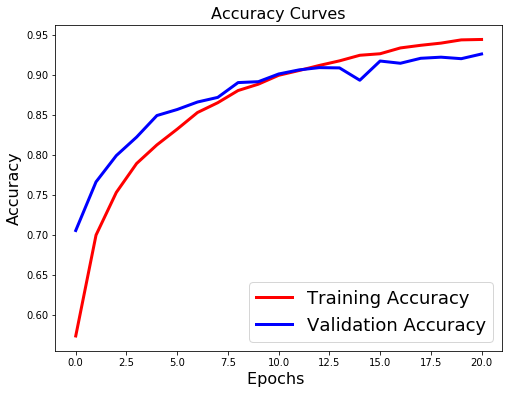

In [18]:
last_good_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'][:last_good_epoch],'r',linewidth=3.0)
plt.plot(history.history['val_acc'][:last_good_epoch],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5,1,'Loss Curves')

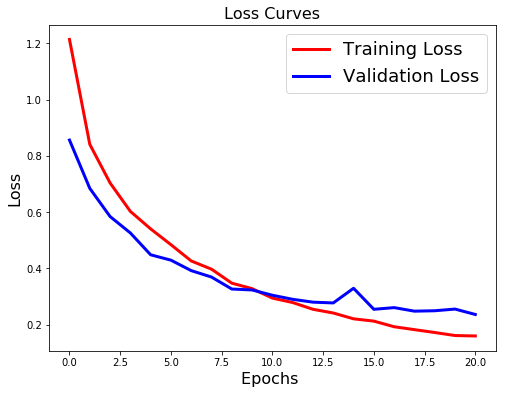

In [19]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'][:last_good_epoch],'r',linewidth=3.0)
plt.plot(history.history['val_loss'][:last_good_epoch],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Second stage of training

In [20]:
epochs = 50
batch_size = 256
history2 = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

Train on 114536 samples, validate on 14317 samples
Epoch 1/50
114536/114536 [==============================] - 39s 342us/step - loss: 0.0773 - acc: 0.9731 - val_loss: 0.2320 - val_acc: 0.9318

Epoch 00001: val_loss improved from 0.23635 to 0.23196, saving model to best_model.hdf5
Epoch 2/50
114536/114536 [==============================] - 39s 343us/step - loss: 0.0654 - acc: 0.9768 - val_loss: 0.2365 - val_acc: 0.9361

Epoch 00002: val_loss did not improve from 0.23196
Epoch 3/50
114536/114536 [==============================] - 39s 342us/step - loss: 0.0647 - acc: 0.9776 - val_loss: 0.2595 - val_acc: 0.9338

Epoch 00003: val_loss did not improve from 0.23196
Epoch 4/50
114536/114536 [==============================] - 39s 342us/step - loss: 0.0676 - acc: 0.9767 - val_loss: 0.2433 - val_acc: 0.9353

Epoch 00004: val_loss did not improve from 0.23196
Epoch 00004: early stopping


In [21]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

Test accuracy: 93.27 %


Text(0.5,1,'Loss Curves')

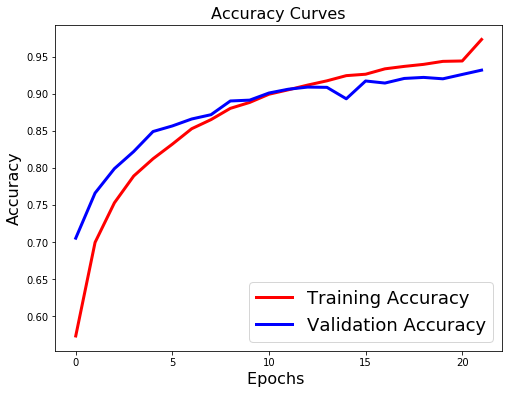

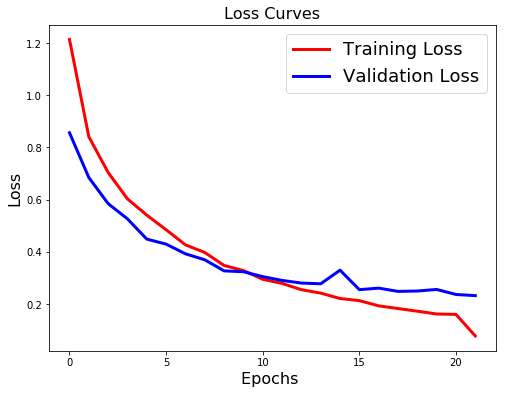

In [22]:
last_good_epoch2 = early_stopping.stopped_epoch - early_stopping.patience + 1

acc_to_plot = history.history['acc'][:last_good_epoch] + history2.history['acc'][:last_good_epoch2]
val_acc_to_plot = history.history['val_acc'][:last_good_epoch] + history2.history['val_acc'][:last_good_epoch2]

plt.figure(figsize=[8,6])
plt.plot(acc_to_plot,'r',linewidth=3.0)
plt.plot(val_acc_to_plot,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


loss_to_plot = history.history['loss'][:last_good_epoch] + history2.history['loss'][:last_good_epoch2]
val_loss_to_plot = history.history['val_loss'][:last_good_epoch] + history2.history['val_loss'][:last_good_epoch2]

plt.figure(figsize=[8,6])
plt.plot(loss_to_plot,'r',linewidth=3.0)
plt.plot(val_loss_to_plot,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Third stage of training

In [23]:
epochs = 50
batch_size = 512
history3 = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

Train on 114536 samples, validate on 14317 samples
Epoch 1/50
114536/114536 [==============================] - 26s 229us/step - loss: 0.0412 - acc: 0.9855 - val_loss: 0.2481 - val_acc: 0.9378

Epoch 00001: val_loss did not improve from 0.23196
Epoch 2/50
114536/114536 [==============================] - 26s 229us/step - loss: 0.0326 - acc: 0.9889 - val_loss: 0.2608 - val_acc: 0.9397

Epoch 00002: val_loss did not improve from 0.23196
Epoch 3/50
114536/114536 [==============================] - 26s 229us/step - loss: 0.0306 - acc: 0.9891 - val_loss: 0.2686 - val_acc: 0.9365

Epoch 00003: val_loss did not improve from 0.23196
Epoch 4/50
114536/114536 [==============================] - 26s 229us/step - loss: 0.0321 - acc: 0.9885 - val_loss: 0.2630 - val_acc: 0.9381

Epoch 00004: val_loss did not improve from 0.23196
Epoch 00004: early stopping


In [24]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

Test accuracy: 93.27 %


Text(0.5,1,'Loss Curves')

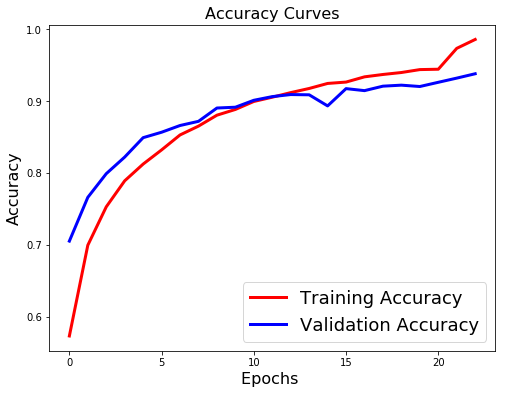

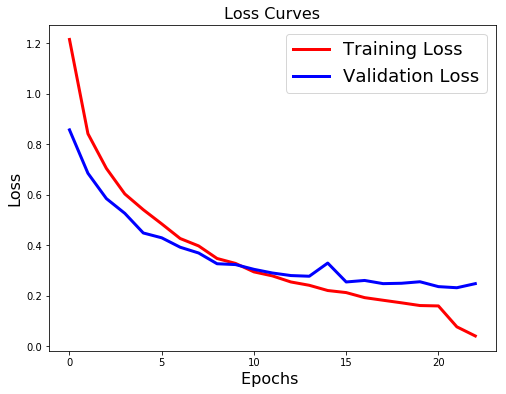

In [25]:
last_good_epoch3 = early_stopping.stopped_epoch - early_stopping.patience + 1

acc_to_plot += history3.history['acc'][:last_good_epoch3]
val_acc_to_plot += history3.history['val_acc'][:last_good_epoch3]

plt.figure(figsize=[8,6])
plt.plot(acc_to_plot,'r',linewidth=3.0)
plt.plot(val_acc_to_plot,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

loss_to_plot += history3.history['loss'][:last_good_epoch3]
val_loss_to_plot += history3.history['val_loss'][:last_good_epoch3]

plt.figure(figsize=[8,6])
plt.plot(loss_to_plot,'r',linewidth=3.0)
plt.plot(val_loss_to_plot,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Fourth stage of training

In [26]:
epochs = 50
batch_size = 1024
history4 = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

Train on 114536 samples, validate on 14317 samples
Epoch 1/50
114536/114536 [==============================] - 19s 168us/step - loss: 0.0342 - acc: 0.9880 - val_loss: 0.2386 - val_acc: 0.9394

Epoch 00001: val_loss did not improve from 0.23196
Epoch 2/50
114536/114536 [==============================] - 19s 167us/step - loss: 0.0238 - acc: 0.9916 - val_loss: 0.2560 - val_acc: 0.9394

Epoch 00002: val_loss did not improve from 0.23196
Epoch 3/50
114536/114536 [==============================] - 19s 169us/step - loss: 0.0201 - acc: 0.9931 - val_loss: 0.2602 - val_acc: 0.9408

Epoch 00003: val_loss did not improve from 0.23196
Epoch 4/50
114536/114536 [==============================] - 19s 167us/step - loss: 0.0190 - acc: 0.9935 - val_loss: 0.2700 - val_acc: 0.9406

Epoch 00004: val_loss did not improve from 0.23196
Epoch 00004: early stopping


In [27]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

Test accuracy: 93.27 %


Text(0.5,1,'Loss Curves')

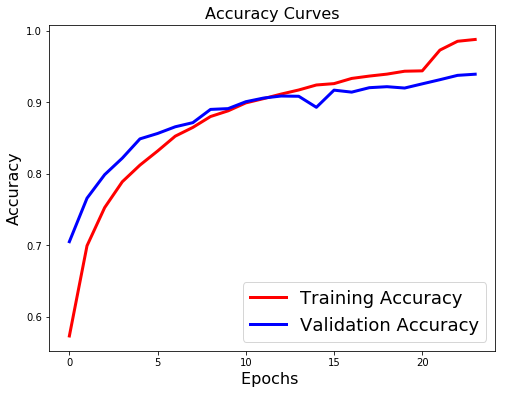

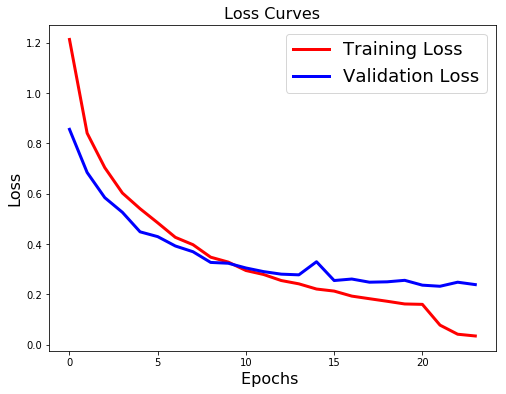

In [28]:
last_good_epoch4 = early_stopping.stopped_epoch - early_stopping.patience + 1

acc_to_plot += history4.history['acc'][:last_good_epoch4]
val_acc_to_plot += history4.history['val_acc'][:last_good_epoch4]

plt.figure(figsize=[8,6])
plt.plot(acc_to_plot,'r',linewidth=3.0)
plt.plot(val_acc_to_plot,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


loss_to_plot += history4.history['loss'][:last_good_epoch4]
val_loss_to_plot += history4.history['val_loss'][:last_good_epoch4]

plt.figure(figsize=[8,6])
plt.plot(loss_to_plot,'r',linewidth=3.0)
plt.plot(val_loss_to_plot,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Fifth stage of training

In [29]:
epochs = 50
batch_size = 2048
history5 = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

Train on 114536 samples, validate on 14317 samples
Epoch 1/50
114536/114536 [==============================] - 15s 135us/step - loss: 0.0326 - acc: 0.9893 - val_loss: 0.2416 - val_acc: 0.9400

Epoch 00001: val_loss did not improve from 0.23196
Epoch 2/50
114536/114536 [==============================] - 16s 136us/step - loss: 0.0216 - acc: 0.9926 - val_loss: 0.2540 - val_acc: 0.9394

Epoch 00002: val_loss did not improve from 0.23196
Epoch 3/50
114536/114536 [==============================] - 15s 135us/step - loss: 0.0181 - acc: 0.9938 - val_loss: 0.2653 - val_acc: 0.9414

Epoch 00003: val_loss did not improve from 0.23196
Epoch 4/50
114536/114536 [==============================] - 15s 134us/step - loss: 0.0153 - acc: 0.9946 - val_loss: 0.2725 - val_acc: 0.9392

Epoch 00004: val_loss did not improve from 0.23196
Epoch 00004: early stopping


In [30]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

Test accuracy: 93.27 %


Text(0.5,1,'Loss Curves')

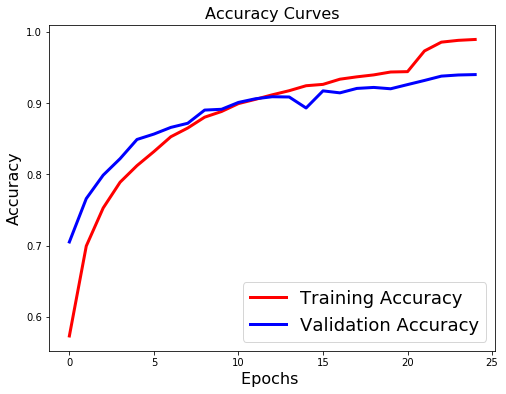

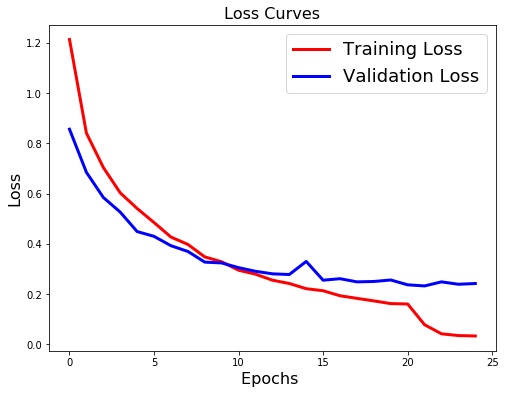

In [31]:
last_good_epoch5 = early_stopping.stopped_epoch - early_stopping.patience + 1

acc_to_plot += history5.history['acc'][:last_good_epoch5]
val_acc_to_plot += history5.history['val_acc'][:last_good_epoch5]

plt.figure(figsize=[8,6])
plt.plot(acc_to_plot,'r',linewidth=3.0)
plt.plot(val_acc_to_plot,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


loss_to_plot += history5.history['loss'][:last_good_epoch5]
val_loss_to_plot += history5.history['val_loss'][:last_good_epoch5]

plt.figure(figsize=[8,6])
plt.plot(loss_to_plot,'r',linewidth=3.0)
plt.plot(val_loss_to_plot,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

<br>
Save model and scaler.

In [32]:
from sklearn.externals import joblib

model.save("last_models/network")
joblib.dump(scaler, "last_models/scaler")

['last_models/scaler']

<br>
Examples of prediction.

In [33]:
df = get_dataframe(join("cv_corpus_v1", "cv-valid-test.csv"))
df.head(10)

,filename,text,up_votes,down_votes,age,gender,accent,duration
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
5,cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of pe...,4,1,twenties,male,us,NaN
6,cv-valid-test/sample-000006.mp3,strange images passed through my mind,3,0,twenties,male,NaN,NaN
7,cv-valid-test/sample-000007.mp3,the sheep had taught him that,2,0,thirties,male,NaN,NaN
8,cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever...,1,0,thirties,male,england,NaN
9,cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky no...,3,0,fifties,male,us,NaN
11,cv-valid-test/sample-000011.mp3,they made the boy continue digging but he foun...,2,0,twenties,male,NaN,NaN
14,cv-valid-test/sample-000014.mp3,follow the instructions here,1,0,twenties,male,scotland,NaN
16,cv-valid-test/sample-000016.mp3,the shop is closed on mondays,1,0,twenties,male,NaN,NaN


In [34]:
def test_prediction(df, model, scaler, path):
    features = feature_extraction(path)
    gender = features[0]
    features = scaler.transform(features.reshape(1, -1))  # reshape because we have a single sample
    features = features[0]   # beacause the shape is (1, 24), but we want (24, ) as shape
    features[0] = gender     # in this way the gender will be always +1, 0 or -1

    print("true age:      ", get_age(df, path))
    prediction = model.predict(np.expand_dims(features, axis=0))
    print("predicted age: ", labels[np.argmax(prediction)])
    

# load model and scaler
model = models.load_model("best_model/network")
scaler = joblib.load("best_model/scaler")

path = join("cv_corpus_v1", "wav-files", "cv-valid-test", "sample-000001.wav")
play_sound(path)
test_prediction(df, model, scaler, path)

true age:       twenties
predicted age:  twenties


In [35]:
path = join("cv_corpus_v1", "wav-files", "cv-valid-test", "sample-000009.wav")
play_sound(path)
test_prediction(df, model, scaler, path)

true age:       fifties
predicted age:  fifties


<br>
Confusion matrix.

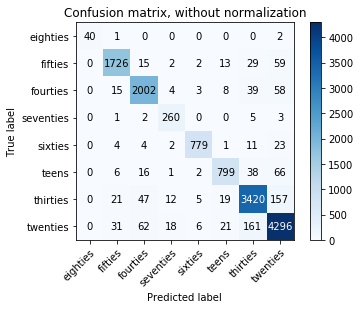

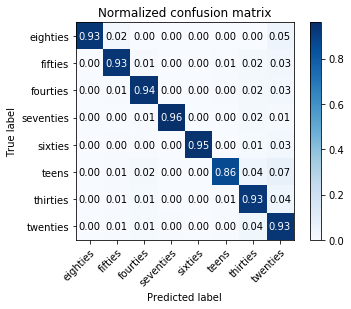

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# adapted from scikit-learn tutorial
def plot_confusion_matrix(y_test, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):    
    cm = confusion_matrix(y_test, y_pred)  # Compute confusion matrix
    
    classes = [labels[el] for el in unique_labels(y_test, y_pred)]  # Only use the labels that appear in the data
    #classes = labels[unique_labels(y_test, y_pred)]  
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),           # We want to show all ticks...
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,  # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax


model = models.load_model("best_model/network")
y_pred = model.predict(x_test)
y_pred = np.asarray([np.argmax(el) for el in y_pred])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

<br>
Trying with my voice.

In [38]:
labels = ['eighties', 'fifties', 'fourties', 'seventies', 'sixties', 'teens', 'thirties', 'twenties']
gender_dict = {"male": -1, "female": +1, "other": 0}

def app_feature_extraction(path, gender, sampling_rate = 48000):
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return np.asarray(features, dtype=float)


def my_voice_prediction(path, gender, model, scaler, test_number):
    features = app_feature_extraction(path, gender)
    gender = features[0]
    features = scaler.transform(features.reshape(1, -1))  # reshape because we have a single sample
    features = features[0]   # beacause the shape is (1, 24), but we want (24, ) as shape
    features[0] = gender     # in this way the gender will be always +1, 0 or -1
    prediction = model.predict(np.expand_dims(features, axis=0))
    print("predicted age of test{}: {}".format(test_number, labels[np.argmax(prediction)]))
        

gender = gender_dict["male"]
model = models.load_model("best_model/network")
scaler = joblib.load("best_model/scaler")

print("true age: 24")
my_voice_prediction("audio_tests/test1.wav", gender, model, scaler, test_number=1)
my_voice_prediction("audio_tests/test2.wav", gender, model, scaler, test_number=2)
my_voice_prediction("audio_tests/test3.wav", gender, model, scaler, test_number=3)
my_voice_prediction("audio_tests/test4.wav", gender, model, scaler, test_number=4)
my_voice_prediction("audio_tests/test5.wav", gender, model, scaler, test_number=5)
my_voice_prediction("audio_tests/test6.wav", gender, model, scaler, test_number=6)
my_voice_prediction("audio_tests/test7.wav", gender, model, scaler, test_number=7)
my_voice_prediction("audio_tests/test8.wav", gender, model, scaler, test_number=8)
my_voice_prediction("audio_tests/test9.wav", gender, model, scaler, test_number=9)
my_voice_prediction("audio_tests/test10.wav", gender, model, scaler, test_number=10)

true age: 24
predicted age of test1: fourties
predicted age of test2: thirties
predicted age of test3: fourties
predicted age of test4: twenties
predicted age of test5: twenties
predicted age of test6: twenties
predicted age of test7: twenties
predicted age of test8: twenties
predicted age of test9: fourties
predicted age of test10: twenties
